# Bitcoin & Ethereum LSTM
We're going to employ a **Long Short Term Memory (LSTM)** model; it's a particular type of deep learning model that is well suited to time series data (or any data with temporal/spatial/structural order e.g. movies, sentences, etc.). 

# Data

> dataset on Kaggle: https://www.kaggle.com/mczielinski/bitcoin-historical-data  
  Bitcoin prices by minute for the last few years

Over this timescale, noise could overwhelm the signal, so we'll opt for daily prices. The issue here is that we may have not sufficient data (we'll have hundreds of rows rather than thousands or millions). In deep learning, no model can overcome a severe lack of data.  
I also don't want to rely on static files, as that'll complicate the process of updating the model in the future with new data. Instead, we'll aim to pull data from websites and APIs.  
As we'll be combining multiple cryptos in one model, it's probably a good idea to pull the data from one source. We'll use [coinmarketcap.com](https://coinmarketcap.com). 

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Bitcoin information

In [2]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))

# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0

# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')

# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-20,8286.88,8880.23,8244.54,8845.83,8438110000,140777000000
1,2018-04-19,8159.27,8298.69,8138.78,8294.31,7063210000,138591000000
2,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000
3,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000
4,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000


# Ethereum information

In [3]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-20,567.99,618.72,560.28,615.72,2849470000,56188700000
1,2018-04-19,524.04,567.89,523.26,567.89,2256870000,51829900000
2,2018-04-18,503.31,525.09,503.05,524.79,1762940000,49769600000
3,2018-04-17,511.14,518.03,502.56,502.89,1760360000,50534000000
4,2018-04-16,532.07,534.20,500.25,511.15,1758980000,52592200000


# prepare data

In [4]:
# getting the Bitcoin and Eth logos
import sys
from PIL import Image
import io

import urllib2 as urllib
bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.8), int(eth_im.size[1]*0.8)), Image.ANTIALIAS)

In [5]:
# rename columns to differentiate the column names for two coins
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

In [6]:
# only take records starting from 2016
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']

for coins in ['bt_', 'eth_']: 
    kwargs = {coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-04-20,8286.88,8880.23,8244.54,8845.83,8438110000,140777000000,567.99,618.72,560.28,615.72,2849470000,56188700000,0.067450,0.084033
1,2018-04-19,8159.27,8298.69,8138.78,8294.31,7063210000,138591000000,524.04,567.89,523.26,567.89,2256870000,51829900000,0.016551,0.083677
2,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000,503.31,525.09,503.05,524.79,1762940000,49769600000,0.027565,0.042677
3,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000,511.14,518.03,502.56,502.89,1760360000,50534000000,-0.021008,-0.016140
4,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000,532.07,534.20,500.25,511.15,1758980000,52592200000,-0.033451,-0.039318


# Training, Test

In time series models, we generally train on one period of time and then test on another separate period. Rather arbitrarily, I'll set the **cut-off date** to June 1st 2017 (i.e. model will be trained on data before that date and assessed on data after it).

In [7]:
def draw_train_test(split_date, ax, prefix, y_label, logo_img, img_x, img_y):
    ax.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
            market_info[market_info['Date'] < split_date]['%s_Close' %(prefix)], 
            color='#B08FC7', label='Training')
    ax.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
            market_info[market_info['Date'] >= split_date]['%s_Close' %(prefix)], 
            color='#8FBAC8', label='Test')
    ax.set_ylabel(y_label,fontsize=12)

    fig.figimage(logo_img.resize((int(logo_img.size[0]*0.65), int(logo_img.size[1]*0.65)), Image.ANTIALIAS), 
                 img_x, img_y, zorder=3, alpha=.5)

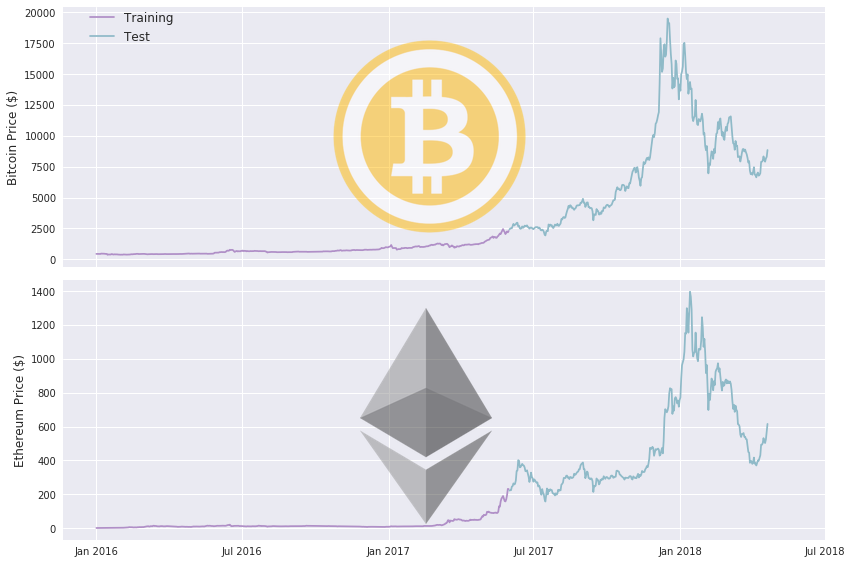

In [8]:
split_date = '2017-06-01'
sns.set()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8))
draw_train_test(split_date, ax1, 'bt', 'Bitcoin Price ($)', bitcoin_im, 220, 270)
draw_train_test(split_date, ax2, 'eth', 'Ethereum Price ($)', eth_im, 360, 40)

ax1.set_xticks([datetime.date(i,j,1) for i in range(2016,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2016,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y') for i in range(2016,2019) for j in [1,7]])

plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 12})
plt.show()

> You can see that the training period mostly consists of periods when cryptos were relatively cheaper. As such, the training data may not be representative of the test data, undermining the model's ability to generalise to unseen data.

# useful function to display prediction performance

In [9]:
def overlay_predict_actual(x, y_actual, y_pred, ax, y_label):
    ax.plot(x, y_actual, label='Actual')
    ax.plot(x, y_pred, label='Predict')
    ax.set_ylabel(y_label, fontsize=12)
    
def draw_pred_performance(x, bt_actual, bt_pred, eth_actual, eth_pred, title):
    sns.set()
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 8), sharex=True)
    overlay_predict_actual(x, bt_actual, bt_pred, ax1, 'Bitcoin Price ($)')
    overlay_predict_actual(x, eth_actual, eth_pred, ax2, 'Etherum Price ($)')
    
    xticks = []
    for year in range(2017, 2019):
        if year == 2017:
            months = range(6, 13)
        if year == 2018:
            months = range(1, 6)
        for m in months:
            xticks.append(datetime.date(year, m, 1))
    
    ax1.set_xticks(xticks)
    ax1.set_xticklabels('')
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([xtick.strftime('%b %Y') for xtick in xticks])

    ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size': 12})
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

# Long Short Term Memory (LSTM)

In [10]:
# create more features
for coins in ['bt_', 'eth_']: 
    kwargs = {coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
              coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

- **close_off_high** represents the gap between the closing price and price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively.  
- **volatility** columns are simply the difference between high and low price divided by the opening price. 

In [11]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
840,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
839,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
838,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
837,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
836,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


Our LSTM model will use previous data (both bitcoin and eth) to predict the next day's closing price of a specific coin. We must decide how many previous days it will have access to.   
Again, it's rather arbitrary, but I'll opt for 10 days, as it's a nice round number.   
We build little data frames consisting of 10 consecutive days of data (called windows), so the first window will consist of the 0-9th rows of the training set (Python is zero-indexed), the second will be the rows 1-10, etc.   Picking a small window size means we can feed more windows into our model; the downside is that the model may not have sufficient information to detect complex long term behaviours (if such things exist).   

# prepare training and test data for LSTM

In [12]:
# window size: 10 days
window_len = 10
# we need to normalize the inputs
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

def lstm_data(dataset):
    dataset = dataset.drop('Date', 1)

    LSTM_inputs = []
    for i in range(len(dataset)-window_len):
        temp_set = dataset[i:(i+window_len)].copy()
        for col in norm_cols:
            # make the value into rate
            temp_set.loc[:, col] = temp_set[col] * 1.0 / temp_set[col].iloc[0] - 1
        LSTM_inputs.append(temp_set)

    # outputs are also rates now
    LSTM_outputs_bt = (dataset['bt_Close'][window_len:].values/dataset['bt_Close'][:-window_len].values)-1
    LSTM_outputs_eth = (dataset['eth_Close'][window_len:].values/dataset['eth_Close'][:-window_len].values)-1
    LSTM_outputs = [LSTM_outputs_bt, LSTM_outputs_eth]
    
    return LSTM_inputs, LSTM_outputs

In [13]:
%%time
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
LSTM_training_inputs, LSTM_training_outputs = lstm_data(training_set)
LSTM_test_inputs, LSTM_test_outputs = lstm_data(test_set)

CPU times: user 2.07 s, sys: 3.99 ms, total: 2.07 s
Wall time: 2.07 s


In [14]:
print LSTM_training_outputs[0][0]
print LSTM_training_outputs[1][0]

0.03246379481039763
0.11811515320287258


In [15]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
840,0.000000,0.000000,-0.560641,0.020292,0.000000,0.000000,-0.418477,0.025040
839,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
838,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
837,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
836,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
835,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
834,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
833,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
832,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
831,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


In [16]:
# use numpy array
LSTM_training_inputs = np.array([np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs])
LSTM_test_inputs = np.array([np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs])

# LSTM model with Keras

In [17]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

/home/saucecat/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
def build_model(inputs, output_size, neurons, activ_func='linear', 
                dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    return model

# check whether Keras is using GPU

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 972751770184346435
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7490528871
locality {
  bus_id: 1
}
incarnation: 8985763124292578991
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [20]:
# random seed for reproducibility
np.random.seed(25)

# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons=20)
eth_model_outputs = LSTM_training_outputs[1]

In [21]:
%%time
eth_history = eth_model.fit(LSTM_training_inputs, eth_model_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 7s - loss: 0.1466
Epoch 2/50
 - 5s - loss: 0.1107
Epoch 3/50
 - 5s - loss: 0.1027
Epoch 4/50
 - 5s - loss: 0.0924
Epoch 5/50
 - 5s - loss: 0.0887
Epoch 6/50
 - 5s - loss: 0.0832
Epoch 7/50
 - 5s - loss: 0.0794
Epoch 8/50
 - 5s - loss: 0.0766
Epoch 9/50
 - 5s - loss: 0.0767
Epoch 10/50
 - 5s - loss: 0.0757
Epoch 11/50
 - 5s - loss: 0.0775
Epoch 12/50
 - 5s - loss: 0.0782
Epoch 13/50
 - 5s - loss: 0.0743
Epoch 14/50
 - 5s - loss: 0.0729
Epoch 15/50
 - 5s - loss: 0.0714
Epoch 16/50
 - 5s - loss: 0.0709
Epoch 17/50
 - 5s - loss: 0.0732
Epoch 18/50
 - 5s - loss: 0.0702
Epoch 19/50
 - 5s - loss: 0.0700
Epoch 20/50
 - 5s - loss: 0.0678
Epoch 21/50
 - 5s - loss: 0.0691
Epoch 22/50
 - 6s - loss: 0.0684
Epoch 23/50
 - 5s - loss: 0.0688
Epoch 24/50
 - 5s - loss: 0.0624
Epoch 25/50
 - 5s - loss: 0.0678
Epoch 26/50
 - 5s - loss: 0.0638
Epoch 27/50
 - 5s - loss: 0.0657
Epoch 28/50
 - 5s - loss: 0.0642
Epoch 29/50
 - 5s - loss: 0.0691
Epoch 30/50
 - 5s - loss: 0.0707
Epoch 31/50
 - 5s -

### If everything went to plan, then we'd expect the training error to have gradually decreased over time.

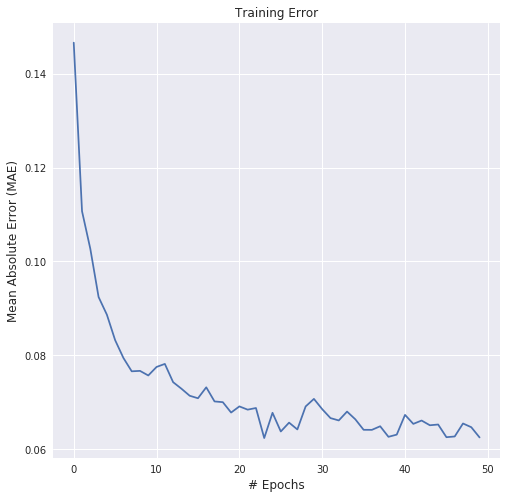

In [23]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 8))

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)

plt.show()

# model performance on the training set 
- (data before June 2017)

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [26]:
pred = eth_model.predict(LSTM_training_inputs)

In [68]:
def plot_lstm_result(x, y_actual, y_actual_value, y_pred, y_pred_value, xticks, title, 
                     y_label, axin_ylim=None, zoom=True, zoom_factor=3):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

    ax1.set_xticks(xticks)
    ax1.set_xticklabels([xtick.strftime('%b %Y') for xtick in xticks])
    
    overlay_predict_actual(x, y_actual_value, y_pred_value, ax1, y_label)
    
    ax1.set_title(title)
    ax1.set_ylabel(y_label, fontsize=12)
    ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size': 12})
    
    loss = np.mean(np.abs(np.transpose(y_pred+1) - y_actual))
    
    ax1.annotate('MAE: %.4f' %loss, xy=(0.75, 0.9), xycoords='axes fraction',
                 xytext=(0.75, 0.9), textcoords='axes fraction')
    
    if zoom:
        # figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
        axins = zoomed_inset_axes(ax1, zoom_factor, loc=10) # zoom-factor: 3.35, location: centre
        axins.set_xticks(xticks)
        overlay_predict_actual(x, y_actual_value, y_pred_value, axins, y_label)

        axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
        axins.set_ylim(axin_ylim)
        axins.set_xticklabels('')
        mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
    plt.show()

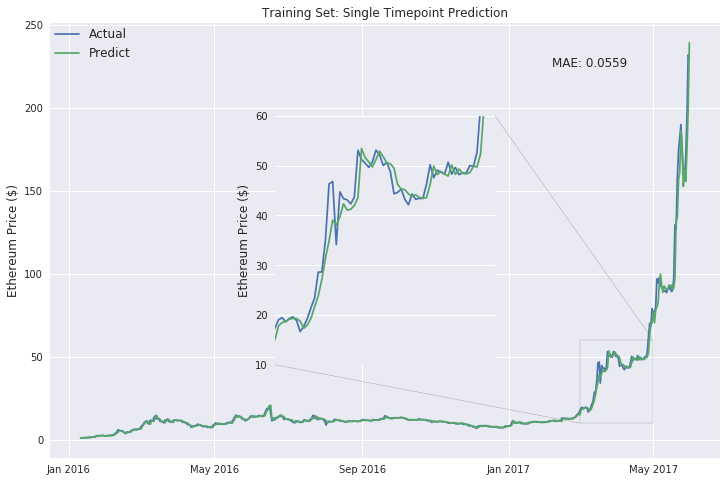

In [69]:
x = model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime)
xticks = [datetime.date(i,j,1) for i in range(2016, 2018) for j in [1,5,9]]

y_actual = training_set['eth_Close'].values[window_len:] / training_set['eth_Close'].values[:-window_len]
y_actual_value = training_set['eth_Close'][window_len:]
y_pred = eth_model.predict(LSTM_training_inputs)
y_pred_value = ((np.transpose(y_pred) + 1) * training_set['eth_Close'].values[:-window_len])[0]

title = 'Training Set: Single Timepoint Prediction'
y_label = 'Ethereum Price ($)'

plot_lstm_result(x, y_actual, y_actual_value, y_pred, y_pred_value, xticks, title, y_label, (10, 60))

# model performance on test set

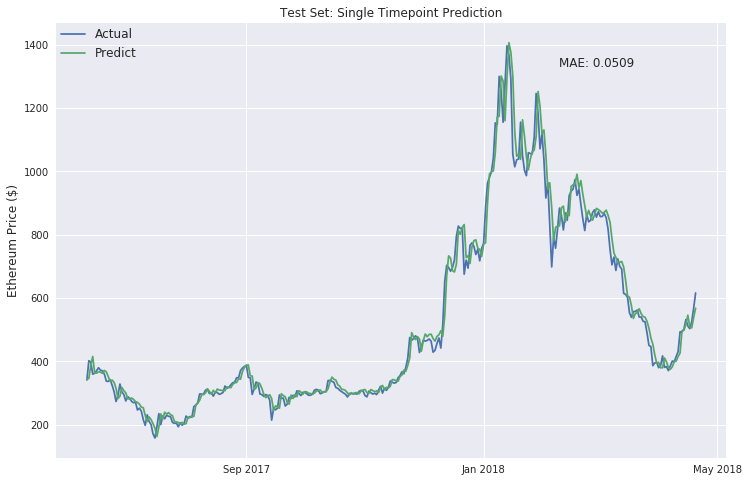

In [70]:
x = model_data[model_data['Date'] >= split_date]['Date'][window_len:].astype(datetime.datetime)
xticks = [datetime.date(i,j,1) for i in range(2017, 2019) for j in [1,5,9]]

y_actual = test_set['eth_Close'].values[window_len:] / test_set['eth_Close'].values[:-window_len]
y_actual_value = test_set['eth_Close'][window_len:]
y_pred = eth_model.predict(LSTM_test_inputs)
y_pred_value = ((np.transpose(y_pred) + 1) * test_set['eth_Close'].values[:-window_len])[0]

title = 'Test Set: Single Timepoint Prediction'
y_label = 'Ethereum Price ($)'

plot_lstm_result(x, y_actual, y_actual_value, y_pred, y_pred_value, xticks, title, y_label, zoom=False)

- The predicted price regularly seems equivalent to the actual price just shifted one day later (e.g. the drop in mid-July). 
- Furthermore, the model seems to be systemically overestimating the future value of Ether (join the club, right?), as the predicted line near always runs higher than the actual line. 
- I suspect this is because the training data represents a period during which the price of Ether rose astronomically, so it expects that trend to continue (don't we all). 

In [48]:
# random seed for reproducibility
np.random.seed(25)

# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
bt_model_outputs = LSTM_training_outputs[0]

In [49]:
%%time
bt_history = bt_model.fit(LSTM_training_inputs, bt_model_outputs, epochs=50, batch_size=32, verbose=2, shuffle=True)

Epoch 1/50
 - 0s - loss: 0.1275
Epoch 2/50
 - 0s - loss: 0.0966
Epoch 3/50
 - 0s - loss: 0.0854
Epoch 4/50
 - 0s - loss: 0.0744
Epoch 5/50
 - 0s - loss: 0.0726
Epoch 6/50
 - 0s - loss: 0.0700
Epoch 7/50
 - 0s - loss: 0.0631
Epoch 8/50
 - 0s - loss: 0.0613
Epoch 9/50
 - 0s - loss: 0.0539
Epoch 10/50
 - 0s - loss: 0.0572
Epoch 11/50
 - 0s - loss: 0.0529
Epoch 12/50
 - 0s - loss: 0.0485
Epoch 13/50
 - 0s - loss: 0.0451
Epoch 14/50
 - 0s - loss: 0.0478
Epoch 15/50
 - 0s - loss: 0.0448
Epoch 16/50
 - 0s - loss: 0.0417
Epoch 17/50
 - 0s - loss: 0.0415
Epoch 18/50
 - 0s - loss: 0.0398
Epoch 19/50
 - 0s - loss: 0.0388
Epoch 20/50
 - 0s - loss: 0.0386
Epoch 21/50
 - 0s - loss: 0.0358
Epoch 22/50
 - 0s - loss: 0.0358
Epoch 23/50
 - 0s - loss: 0.0365
Epoch 24/50
 - 0s - loss: 0.0361
Epoch 25/50
 - 0s - loss: 0.0345
Epoch 26/50
 - 0s - loss: 0.0337
Epoch 27/50
 - 0s - loss: 0.0332
Epoch 28/50
 - 0s - loss: 0.0329
Epoch 29/50
 - 0s - loss: 0.0334
Epoch 30/50
 - 0s - loss: 0.0334
Epoch 31/50
 - 0s -

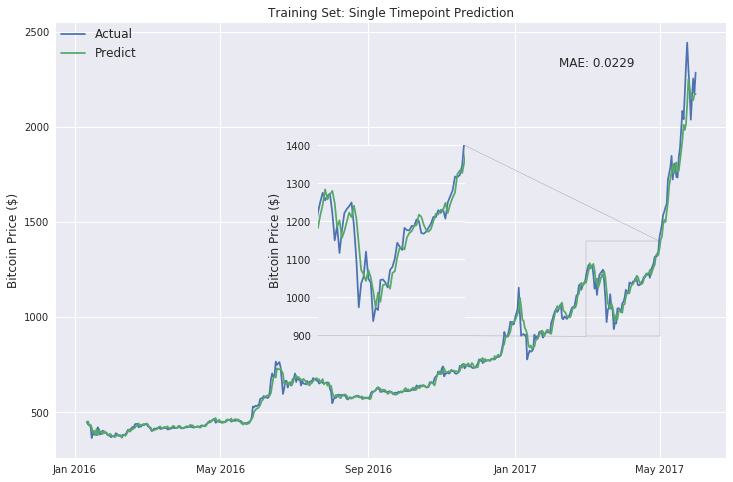

In [72]:
x = model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime)
xticks = [datetime.date(i,j,1) for i in range(2016, 2018) for j in [1,5,9]]

y_actual = training_set['bt_Close'].values[window_len:] / training_set['bt_Close'].values[:-window_len]
y_actual_value = training_set['bt_Close'][window_len:]
y_pred = bt_model.predict(LSTM_training_inputs)
y_pred_value = ((np.transpose(y_pred) + 1) * training_set['bt_Close'].values[:-window_len])[0]

title = 'Training Set: Single Timepoint Prediction'
y_label = 'Bitcoin Price ($)'

plot_lstm_result(x, y_actual, y_actual_value, y_pred, y_pred_value, xticks, title, 
                 y_label, (900, 1400), zoom_factor=2)

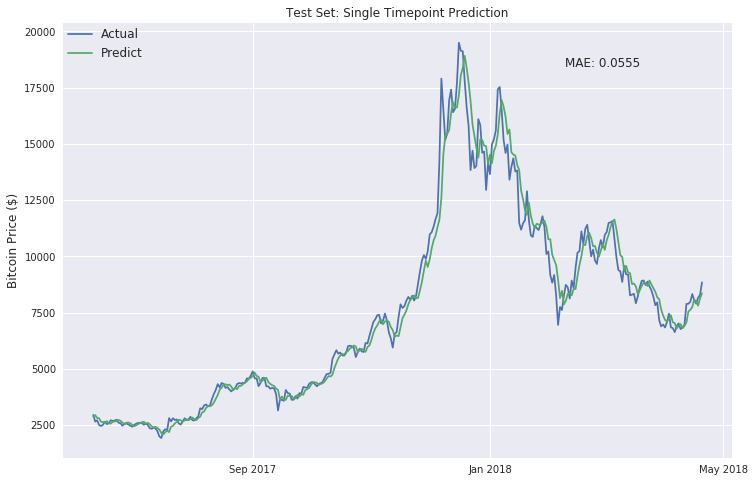

In [74]:
x = model_data[model_data['Date'] >= split_date]['Date'][window_len:].astype(datetime.datetime)
xticks = [datetime.date(i,j,1) for i in range(2017, 2019) for j in [1,5,9]]

y_actual = test_set['bt_Close'].values[window_len:] / test_set['bt_Close'].values[:-window_len]
y_actual_value = test_set['bt_Close'][window_len:]
y_pred = bt_model.predict(LSTM_test_inputs)
y_pred_value = ((np.transpose(y_pred) + 1) * test_set['bt_Close'].values[:-window_len])[0]

title = 'Test Set: Single Timepoint Prediction'
y_label = 'Bitcoin Price ($)'

plot_lstm_result(x, y_actual, y_actual_value, y_pred, y_pred_value, xticks, title, y_label, zoom=False)

> As I've stated earlier, single point predictions can be deceptive. Looking more closely, you'll notice that, again, the predicted values regularly mirror the previous values (e.g. October). 

Our fancy deep learning LSTM model has partially reproducted a [autregressive (AR) model](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) of some order `p`, where future values are simply the weighted sum of the previous `p` values. We can define an AR model in these mathematical terms:  

\begin{align}
PredPrice_{t} & = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}

The good news is that AR models are commonly employed in time series tasks (e.g. [stock market prices](https://upcommons.upc.edu/bitstream/handle/2099/3572/04marcek.pdf)), so the LSTM model appears to have landed on a sensible solution. The bad news is that it's a waste of the LSTM capabilities, we could have a built a much simpler AR model in much less time and probably achieved similar results (though the title of this post would have been much less clickbaity). [More complex does not automatically equal more accurate](https://pdfs.semanticscholar.org/696c/2fa5697f58914921ff37d69ced44ddea143f.pdf)). 

# LSTM models to predict crypto prices for the next 5 days

In [77]:
# random seed for reproducibility
np.random.seed(25)

pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)

In [78]:
def lstm_output_day_range(dataset, pred_range):
    
    LSTM_outputs = []
    bt_outputs, eth_outputs = [], []
    for i in range(window_len, len(dataset)-pred_range):
        bt_outputs.append((dataset['bt_Close'][i:i+pred_range].values / dataset['bt_Close'].values[i-window_len])-1)
        eth_outputs.append((dataset['eth_Close'][i:i+pred_range].values / dataset['eth_Close'].values[i-window_len])-1)

    LSTM_outputs = [np.array(bt_outputs), np.array(eth_outputs)]
    return LSTM_outputs

In [79]:
LSTM_training_outputs = lstm_output_day_range(training_set, pred_range)
LSTM_test_outputs = lstm_output_day_range(test_set, pred_range)

In [80]:
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs[0], 
                          epochs=50, batch_size=32, verbose=2, shuffle=True)
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs[1], 
                            epochs=50, batch_size=32, verbose=2, shuffle=True)

Epoch 1/50
 - 0s - loss: 0.1642
Epoch 2/50
 - 0s - loss: 0.1212
Epoch 3/50
 - 0s - loss: 0.1041
Epoch 4/50
 - 0s - loss: 0.0949
Epoch 5/50
 - 0s - loss: 0.0868
Epoch 6/50
 - 0s - loss: 0.0832
Epoch 7/50
 - 0s - loss: 0.0760
Epoch 8/50
 - 0s - loss: 0.0744
Epoch 9/50
 - 0s - loss: 0.0702
Epoch 10/50
 - 0s - loss: 0.0688
Epoch 11/50
 - 0s - loss: 0.0655
Epoch 12/50
 - 0s - loss: 0.0634
Epoch 13/50
 - 0s - loss: 0.0622
Epoch 14/50
 - 0s - loss: 0.0608
Epoch 15/50
 - 0s - loss: 0.0606
Epoch 16/50
 - 0s - loss: 0.0573
Epoch 17/50
 - 0s - loss: 0.0570
Epoch 18/50
 - 0s - loss: 0.0550
Epoch 19/50
 - 0s - loss: 0.0525
Epoch 20/50
 - 0s - loss: 0.0512
Epoch 21/50
 - 0s - loss: 0.0502
Epoch 22/50
 - 0s - loss: 0.0501
Epoch 23/50
 - 0s - loss: 0.0486
Epoch 24/50
 - 0s - loss: 0.0483
Epoch 25/50
 - 0s - loss: 0.0476
Epoch 26/50
 - 0s - loss: 0.0473
Epoch 27/50
 - 0s - loss: 0.0456
Epoch 28/50
 - 0s - loss: 0.0464
Epoch 29/50
 - 0s - loss: 0.0460
Epoch 30/50
 - 0s - loss: 0.0454
Epoch 31/50
 - 0s -

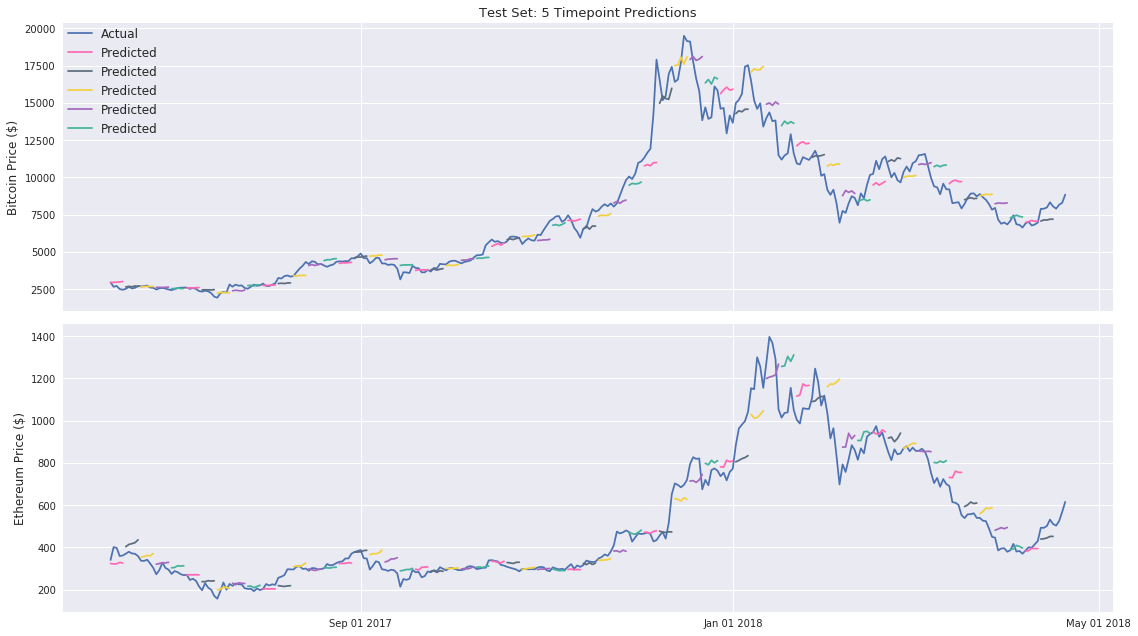

In [92]:
# only check results every 5 days
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16, 9))

xticks = [datetime.date(i,j,1) for i in range(2017, 2019) for j in [1,5,9]]
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)
ax2.set_xticklabels([xtick.strftime('%b %d %Y') for xtick in xticks])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')

for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])
    
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. 
> So there are some grounds for optimism.

# compare LSTM and Random Walks

Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

In [95]:
def lstm_output(dataset):
    LSTM_outputs_bt = (dataset['bt_Close'][window_len:].values/dataset['bt_Close'][:-window_len].values)-1
    LSTM_outputs_eth = (dataset['eth_Close'][window_len:].values/dataset['eth_Close'][:-window_len].values)-1
    LSTM_outputs = [LSTM_outputs_bt, LSTM_outputs_eth]
    
    return LSTM_outputs

In [97]:
LSTM_training_outputs = lstm_output(training_set)
LSTM_test_outputs = lstm_output(test_set)

In [99]:
for rand_seed in range(775,800):
    print(rand_seed)
    np.random.seed(rand_seed)
    
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs, LSTM_training_outputs[0], epochs=50, batch_size=32, 
                   verbose=0, shuffle=True)
    temp_model.save('temp/bt_model_randseed_%d.h5' %rand_seed)
    
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs, LSTM_training_outputs[1], epochs=50, batch_size=32, 
                   verbose=0, shuffle=True)
    temp_model.save('temp/eth_model_randseed_%d.h5'%rand_seed)

775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799


In [100]:
# assuming the previous cell was completed, this cell loads in the different initialisations
# and calculates the average mean absolute error (mae)

from keras.models import load_model

eth_preds = []
bt_preds = []
for rand_seed in range(775,800):
    temp_model = load_model('temp/eth_model_randseed_%d.h5' %rand_seed)
    y_pred = temp_model.predict(LSTM_test_inputs)
    eth_preds.append(np.mean(abs(np.transpose(y_pred)-(test_set['eth_Close'].values[window_len:]/test_set['eth_Close'].values[:-window_len]-1))))
    
    temp_model = load_model('temp/bt_model_randseed_%d.h5' %rand_seed)
    y_pred = temp_model.predict(LSTM_test_inputs)
    bt_preds.append(np.mean(abs(np.transpose(y_pred)- (test_set['bt_Close'].values[window_len:]/test_set['bt_Close'].values[:-window_len]-1))))

In [101]:
eth_random_walk_preds = []
bt_random_walk_preds = []

bt_r_walk_mean = np.mean(market_info[market_info['Date'] < split_date]['bt_day_diff'].values)
bt_r_walk_sd = np.std(market_info[market_info['Date'] < split_date]['bt_day_diff'].values)

eth_r_walk_mean = np.mean(market_info[market_info['Date'] < split_date]['eth_day_diff'].values)
eth_r_walk_sd = np.std(market_info[market_info['Date'] < split_date]['eth_day_diff'].values)

for rand_seed in range(775, 800):
    np.random.seed(rand_seed)
    eth_random_walk_preds.append(
        np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['eth_Close'][window_len:])/np.array(test_set['eth_Close'][:-window_len]))))
    bt_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(bt_r_walk_mean, bt_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['bt_Close'][window_len:])/np.array(test_set['bt_Close'][:-window_len]))))

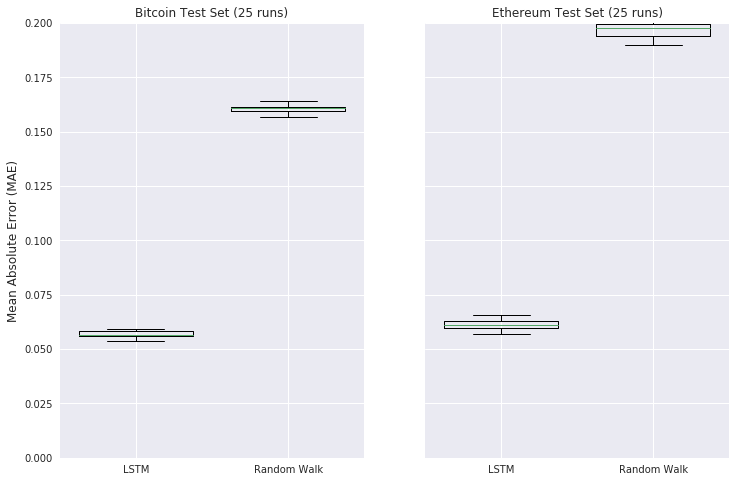

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
sns.set()
ax1.boxplot([bt_preds, bt_random_walk_preds],widths=0.75)
ax1.set_ylim([0, 0.2])
ax2.boxplot([eth_preds, eth_random_walk_preds],widths=0.75)
ax2.set_ylim([0, 0.2])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Bitcoin Test Set (25 runs)')
ax2.set_title('Ethereum Test Set (25 runs)')
ax2.set_yticklabels('')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
plt.show()

Aiming to beat random walks is a pretty low bar. It would be more interesting to compare the LSTM model against more appropriate time series models (weighted average, autoregression, [ARIMA](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) or Facebook's [Prophet algorithm](https://github.com/facebook/prophet)).   

# Summary

* **Change Loss Function**: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. [More bespoke trading focused loss functions](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) could also move the model towards less conservative behaviours.

* **Penalise conservative AR-type models**: This would incentivise the deep learning algorithm to explore more risky/interesting models. Easier said than done!

* **Get more and/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.